In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import random
import os
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline

In [2]:
n_bins = 15 # Number of bins for calibration estimates

In [3]:
seqmeta = np.load("../../../data/results/100_subsamples_withmeta_MLP_tune_full_300300.npy")

In [4]:
seqonly = np.load("../../../data/results/100_subseq_ensembled_200ksteps_probs_NOmeta.npy")

In [5]:
print(seqmeta.shape)
seqonly.shape

(7466, 1314)


(7466, 1314)

In [6]:
true = pickle.load( open( "../../../data/tts/y_val_ord.pkl", "rb" ) )
true

array([ 142., 1136., 1136., ...,  972., 1269.,  452.])

In [7]:
def acc(pred, true):
    classes = np.argmax(pred, axis=1)
    correct = (classes == true)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def calibration(true, predicted, n_bins):
    """
    Inputs
    true: a vector of indices of the correct class
    predicted: a n_samples x n_labels matrix of softmax probabilities
    n_bins: integer > 0, number of bins to divide the interval [0,1]
    
    Outputs: ECE, MCE, bins, acc_per_bin, conf_per_bin
    """
    true = np.asarray(true,dtype=int)
    bins = np.linspace(0,1, num=n_bins, endpoint=False)
    #print(bins)
    correct = (np.argmax(predicted,axis=1) == true)
    #prob = predicted[list(zip(np.arange(len(true)),true.tolist()))]
    #prob = predicted[np.arange(len(true)),true.tolist()]
    
    # Above is for the correct, this is max confidence
    prob = np.max(predicted,axis=1)
    
    # Now I need to bin the indices of each.
    binned = np.digitize(prob,bins) - 1 # Returns bin index per row
    #print(binned)
    accs = []
    confs = []
    for bin_idx in range(n_bins):
        idxs = np.where(binned == bin_idx)
        subset = correct[idxs]
        accuracy = np.sum(subset) / len(subset)
        conf_subset = prob[idxs]
        confidence = np.sum(conf_subset) / len(conf_subset)
        accs.append(accuracy)
        confs.append(confidence)
    #print(f"acc is {accs}")
    #print(f"confs is {confs}")
    diffs = np.abs(np.asarray(accs) - np.asarray(confs))
    diffs = diffs[~np.isnan(diffs)]
    #print(diffs)
    return np.mean(prob), np.mean(diffs), np.max(diffs), bins, accs, confs

In [8]:
acc(seqmeta,true)

0.7404232520760782

In [9]:
acc(seqonly,true)

0.6644789713367265

In [10]:
def topkacc(pred,true,k):
    topkclasses = np.argsort(pred)[:,-k:]
    correct = ((topkclasses == true[:,None]).any(axis=1))
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [11]:
topkacc(seqonly,true,1)

0.6644789713367265

In [12]:
topkacc(seqmeta,true,1)

0.7404232520760782

FOR SEQUENCE ONLY
Top 1 accuracy is 0.6644789713367265
Top 2 accuracy is 0.7476560407179212
Top 3 accuracy is 0.7800696490758103
Top 4 accuracy is 0.7992231449236539
Top 5 accuracy is 0.8119474953120814
Top 6 accuracy is 0.8215912135012055
Top 7 accuracy is 0.830565229038307
Top 8 accuracy is 0.836726493436914
Top 9 accuracy is 0.8435574604875435
Top 10 accuracy is 0.8499866059469595
Average confidence:0.6555356979370117
ECE:0.07606418991636642
MCE:0.17606578372110704


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


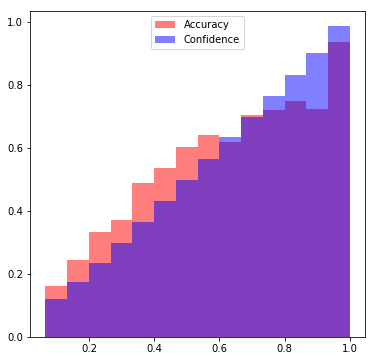

In [13]:
# That works, now check top 10
print("FOR SEQUENCE ONLY")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqonly,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqonly,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()

FOR SEQUENCE AND METADATA
Top 1 accuracy is 0.7404232520760782
Top 2 accuracy is 0.8002946691668898
Top 3 accuracy is 0.828422180551835
Top 4 accuracy is 0.844762925261184
Top 5 accuracy is 0.8562818108759711
Top 6 accuracy is 0.8648540048218591
Top 7 accuracy is 0.8704795070988481
Top 8 accuracy is 0.8759710688454326
Top 9 accuracy is 0.8790517010447362
Top 10 accuracy is 0.8830699169568712
Average confidence:0.7814821600914001
ECE:0.03201866754296369
MCE:0.10940266250324837


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


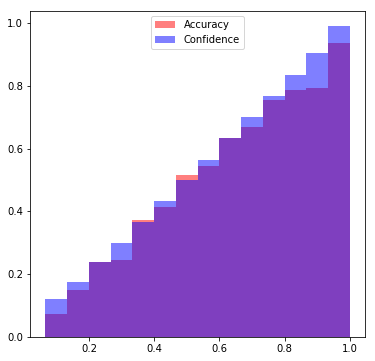

In [14]:
print("FOR SEQUENCE AND METADATA")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqmeta,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqmeta,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()

NIELSEN AND VOIGT
Top 1 accuracy is 0.5712563621751943
Top 2 accuracy is 0.6690329493704795
Top 3 accuracy is 0.7101526922046612
Top 4 accuracy is 0.7339941066166622
Top 5 accuracy is 0.7485936244307527
Top 6 accuracy is 0.7607822126975623
Top 7 accuracy is 0.7701580498258773
Top 8 accuracy is 0.7802035896062148
Top 9 accuracy is 0.7864987945352263
Top 10 accuracy is 0.7921242968122154
Average confidence:0.6413941383361816
ECE:0.0868612446993197
MCE:0.22378535511231917


/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/media/sandias42/ExDrive/Software/Python/Anaconda/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


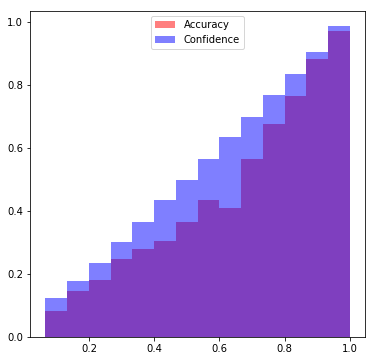

In [23]:
seqonly = seqonly = np.load("../../../data/CNN/VAL_LOGITS_nv_787800.npy")

# That works, now check top 10
print("NIELSEN AND VOIGT")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqonly,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,softmax(seqonly,axis=-1),n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()